## Corners and Lines(10pts)
<em>University of Virginia - Introduction to Computer Vision - Fall 2019 - Vicente Ordonez, Paola Cascante, Ziyan Yang - (vicente@virginia.edu)</em><br/><br/>

In this lab we will apply our knowledge in the lectures in order to find corners and lines in images.



### 1. Detecting Corners (5pts).
In this section we will implement a version of the Harris Corner Detection. You are going to detect the corners in UVA Rotunda. Note that you are not allowed to use any outside library other than the ones explicitly indicated for this question. The idea is for you to implement the Harris corner detector and a variant of it.

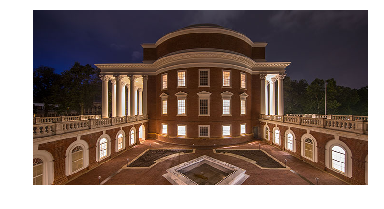

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
import imageio

# Download the images in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~pc9za/rotunda-lg.jpg'
img = imageio.imread(img_url)

# Please attention, in this assignment image is floating point.
img = img.astype('float') / 255.0

# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img); plt.grid(False);plt.axis('off');plt.show()
  
display_image(img)

#### 1.1  Computing $I_x^2$, $I_y^2$ and $I_xI_y$ [1pts]
Compute and display $I_x^2$, $I_y^2$, and $I_xI_y$ using Sobel operators. You are only allowed to use scipy.signal.convolve2d for any convolutional operations. Feel free to reuse your code from the previous assignment.

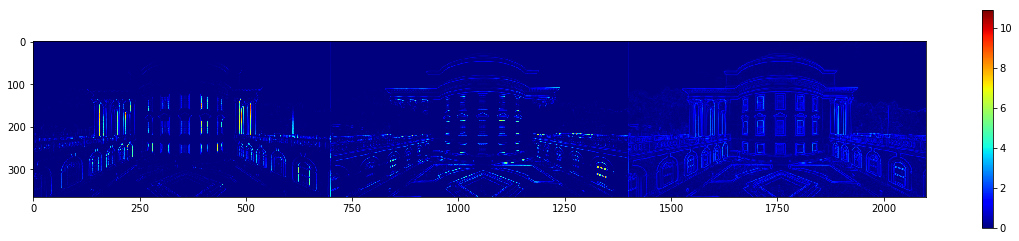

In [0]:
from scipy import signal
from skimage.color import rgb2gray

# Compute Ixx, Iyy and Ixy here.


# Plot Ixx, Iyy, Ixy.
grayscale = rgb2gray(img)
x_convolve = np.matrix([[1,0,-1],[2,0,-2],[1,0,-1]])
y_convolve = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])

Ix = signal.convolve2d(grayscale, x_convolve,mode='same')
Iy = signal.convolve2d(grayscale, y_convolve,mode='same')
Ixx= Ix**2
Iyy= Iy**2
Ixy= (Ixx + Iyy)**0.5 
Iyx= (Ixx + Iyy)**0.5 


plt.figure(figsize=(20,4))
plt.imshow(np.concatenate((Ixx, Iyy, np.abs(Ixy)), axis = 1), 
           cmap =  'jet')
plt.colorbar()
plt.grid(False)
plt.show()



####1.2 Compute the response map R using the Harris criteria and the Szeliski criteria [2pts].
Show side by side the input image with the response map R computed using the original Harris detector with $\alpha=0.05$, and using the Harmonic mean formula proposed by Szeliski. Use a window/patch size of 12x12 to define the momentum matrix M.

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


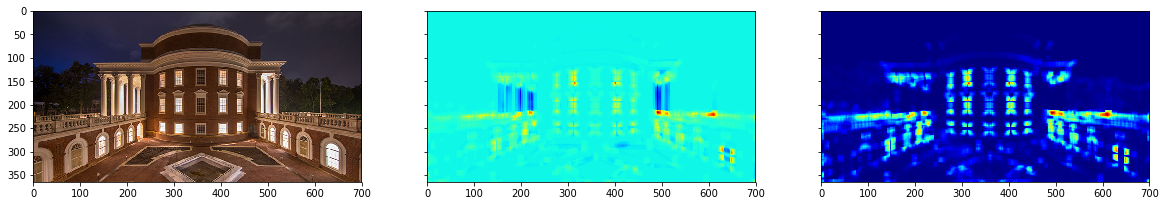

In [0]:
Ixy = Ix*Iy

# Compute the Rmap and RHarmonicMap map responses.
window = np.ones((12, 12))
sigma_xx = signal.convolve2d(Ixx, window,mode='same', boundary='symm')
sigma_yy = signal.convolve2d(Iyy, window,mode='same', boundary='symm')
sigma_xy = signal.convolve2d(Ixy, window,mode='same', boundary='symm')
alpha = 0.05

#RMap
RMap = np.empty([len(sigma_xx), len(sigma_xx[0])])
RHarmonicMap = np.empty([len(sigma_xx), len(sigma_xx[0])])

for x in range(len(sigma_xx)):
  for y in range(len(sigma_xx[x])):
    m = np.matrix([ [sigma_xx[x][y],sigma_xy[x][y]],[sigma_xy[x][y], sigma_yy[x][y]]])
    detm = np.linalg.det(m)
    tracem = np.trace(m)
    RMap[x][y] = detm - alpha*(tracem**2)
    RHarmonicMap[x][y] = 0 if tracem == 0 else float(detm)/float(tracem)

# Plot Harris response outputs.
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize=(20, 4))
ax1.imshow(img);ax1.grid('off')
ax2.imshow(RMap, cmap = 'jet'); ax2.grid('off')
ax3.imshow(RHarmonicMap, cmap ='jet'); ax3.grid('off');

####1.3 Non-max Supression and Final Output [2pts]

Perform non-max supression on the outputs obtained in the previous step so that you get a list of pixels corresponding to corners for each method. Feel free to use any  method you can think of but the general idea is to leave only one point per corner and no two points with high values should be together. An easy way is to just define a minimum distance between corners of 5 pixels. The only pixels surviving (non-zero) after non-max should be the ones that a) pass a threshold (which you are free to define), and b) are the maximum pixel within their neighborhood. I am including outputs as an example of what it should more or less look like at the end.

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


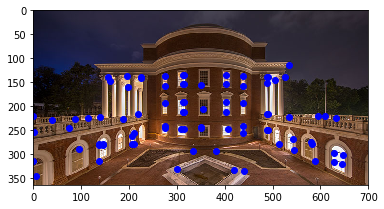

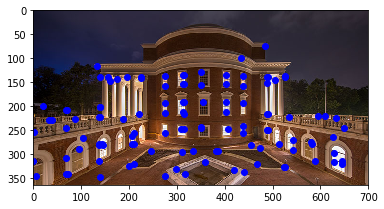

In [0]:
import math

def distance(one, two):
  return math.sqrt(float((one[0] - two[0])**2 + (one[1] - two[1])**2))

def checkUp(map, current, coordinates):
  for x in coordinates:
    if distance(current, x) < 5.0:
      return False
  return True

def nonmax(map):
  coordinates = []
  constant = 35
  size = map.shape
  for x in range(0, size[0]-constant,constant):
    for y in range(0, size[1]-constant,constant):
      max = -10000
      state = False
      for i in range(constant):
        for j in range(constant):
          value = map[x+i][y+j]
          current = [x+i,y+j]  
          if value > max:
            max = value
            c = current
            state = True
      if state and max > 1300:
        coordinates.append([c[0],c[1]])
  return [i[0] for i in coordinates],[i[1] for i in coordinates]

def nonmax2(map):
  coordinates = []
  constant = 35
  size = map.shape
  for x in range(0, size[0]-constant,constant):
    for y in range(0, size[1]-constant,constant):
      max = -10000
      state = False
      for i in range(constant):
        for j in range(constant):
          value = map[x+i][y+j]
          current = [x+i,y+j]  
          if value > max:
            max = value
            c = current
            state = True
      if state and max > 5:
        coordinates.append([c[0],c[1]])
  return [i[0] for i in coordinates],[i[1] for i in coordinates]

# np.nonzero extracts 2d coordinates of non-zero elements.
ys1, xs1 = nonmax(RMap)
ys2, xs2 = nonmax2(RHarmonicMap)
# Method 1: Harris operator original score.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs1, ys1, '.b', markersize=12)
ax.grid('off')

# Method 2: Szeliski's Harmonic mean.
# Show image with corner coordinates marked with blue dots.
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
ax.plot(xs2, ys2, '.b', markersize=12)
ax.grid('off')

**Final Comments:** What happens if you rotate the image? Will it still detect the same corners? What happens if you resize the image? Will it detect the same corners? When will you get more corners detected, if you resize up or resize down the image?

### 2. Detecting Lines (5pts).
In this section we will perform line detection by implementing the Hough Transform.

Image size:  (800, 1200, 3)


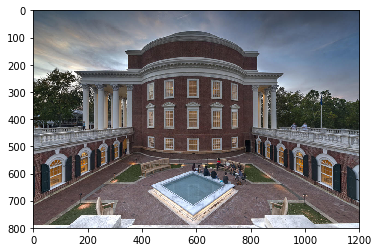

In [0]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen

# Download the image in case the CS webserver goes down.
img_url = 'http://www.cs.virginia.edu/~pc9za/rotunda-lg2.jpg'
img = imageio.imread(img_url)
img = img.astype('float') / 255

# Show the image size.
print('Image size: ', img.shape)

# Plot the image.
def display_image(img):
  plt.figure()
  plt.imshow(img)
  plt.grid(False)
  plt.show()
  
display_image(img)

#### 2.1 Hough Transform [2pts]

Use the Hough Transform to find all the lines in the image. Show the Hough Transform for the UVA Rotunda image.

In [0]:
# img = rgb2gray(img)
img = img.astype('float')
img = (img[:, :, 0] + img[:, :, 1] + img[:, :, 2]) / 3.0

def magnitude(a, b):
  if type(a) == type(b):
    return math.sqrt(a**2 + b**2)

def sobel(size, img, matrix_x, matrix_y):
  result = []
  for x in range(len(img)):
    result.append([])
    for y in range(len(img[x])):
      result[x].append(img[x][y])
  
  for x in range(len(img)-size):
    for y in range(len(img[x])-size):
      value_x = 0
      value_y = 0
      for i in range(size):
        for j in range(size):
          value_x += matrix_x[i][j]*img[x+i][y+j]
          value_y += matrix_y[i][j]*img[x+i][y+j]    
          m = magnitude(value_x,value_y)

      result[x+int(size/2)][y+int(size/2)] = m 
    
  result = np.array(result)
  result[result > 0.4] = 1
  result[result <= 0.4] = 0
  return result
  
size = 3
matrix_x = [[1,2,1],[0,0,0],[-1,-2,-1]]
matrix_y = [[1,0,-1],[2,0,-2],[1,0,-1]]
s = sobel(size, img, matrix_x, matrix_y)

In [0]:
# Your code goes here.
import matplotlib.pyplot as plt
img = s
r, c = img.shape
diag = (r**2+c**2)**0.5

def hough_line(img):
  jump = 1
  size = img.shape
  diag = math.sqrt(size[0]**2 + size[1]**2)

  accumulator = np.empty(shape=(2*int(diag),181))

  for y in range(size[0]):
    for x in range(size[1]):

      if img[y][x] == 1:
        for theta in range(-90,91,jump):
          
          rho = x*np.cos( np.deg2rad(theta)) + y*np.sin(np.deg2rad(theta)) + diag
          accumulator[int(rho)][theta+90]+=1
      
  return accumulator

accumulator = hough_line(img)

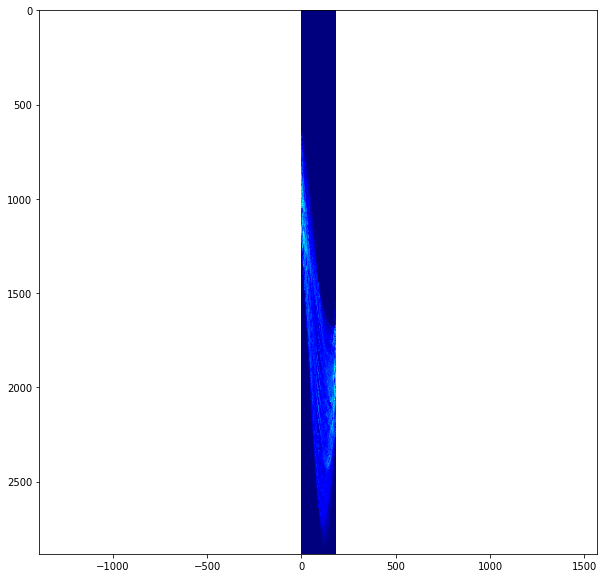

In [0]:
plt.figure(figsize=(10,10))
plt.axes().set_aspect('equal', 'datalim')
plt.imshow(accumulator, cmap =  'jet')
plt.grid(False)
plt.show()

#### 2.2 Line Detection [3pts]
Find the peaks in the Hough Transform computed in the previous step and plot the original images with red lines overlaid showing the detected lines.

In [0]:
# Find the value(s) of (θ, ρ) where H(θ, ρ) is a local
# maximum
# • The detected line in the image is given by
# ρ = x cos θ + y sin θ
def nonmax3(accumulator):
  coordinates = []
  constant = 75

  size = accumulator.shape
  for theta in range(0,len(accumulator) - constant, constant):
    for rho in range(0,len(accumulator[theta]) - constant, constant):
      max = -10000
      state = False
      for i in range(constant):
        for j in range(constant):
          value = accumulator[theta+i][rho+j]
          current = [theta+i,rho+j]  
          if value > max:
            max = value
            c = current
            state = True
      if state and max > 375:
        coordinates.append([c[0],c[1]])
  return [i[0] for i in coordinates],[i[1] for i in coordinates]

ys, xs = nonmax3(accumulator)

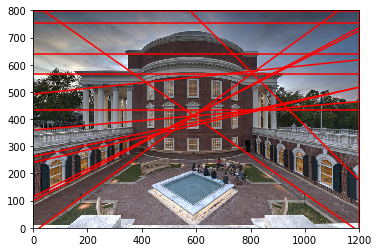

In [0]:
# Your code goes here.
x = np.linspace(0, 1200, 2)
plt.figure()

for index in range(len(xs)):
  theta = xs[index]-90
  rho = ys[index]-diag
  if theta == 0:
    plt.axvline(x=rho, c='r')
  else:
    y = -np.cos(np.deg2rad(theta))*x/np.sin(np.deg2rad(theta)) + rho/np.sin(np.deg2rad(theta))
    plt.plot(x,y,'-r')

img_url = 'http://www.cs.virginia.edu/~pc9za/rotunda-lg2.jpg'
img = imageio.imread(img_url)
img = img.astype('float') / 255
plt.imshow(img, extent=(0,1200,0,800))

**Final Comments:** The Hough Transform detects lines, how would you modify the algorithm to find instead line segments? 